In [2]:
import seaborn as sb
import pandas as pd
import json 
import matplotlib.pyplot as plt


In [3]:
def get_dec_resid_df(checkpoint):
    data_path = f"{checkpoint}/all_dec_resid_results.csv"
    df = pd.read_csv(data_path)
    df = df.rename(columns={'layer': 'Layer', 'component': 'Component'})
    return df


def get_ranks_df(checkpoint):
    data_path = f"{checkpoint}/all_ranks_correct_doc.csv"
    df =  pd.read_csv(data_path)

    def convert(x):
        try:
            return float(x)
        except:
            return float(x.replace('tensor(', '')[:-1])
    df['Rank'] = df['value'].map(convert)
    df = df.rename(columns={'layer': 'Layer', 'component': 'Component'})
    
    return df


In [4]:
sb.set_context("paper")  # can also use "talk", "notebook", "poster" etc.
sb.set_style("whitegrid")  # "white", "dark", "ticks", or "whitegrid"
sb.set_palette("colorblind")


## Residual Stream Contributions (Length, Angle)
### Data Loading

In [5]:
def load_trivia(checkpoint, N=1500):
    data_path = f"{checkpoint}/all_dec_resid_results_{N}.json"
    data = json.load(open(data_path))
    df = pd.DataFrame(data)
    df = df.rename(columns={'layer': 'Layer', 'component': 'Component'})
    return df

In [10]:
example_data = "../../sample_output"
complete_ds = get_dec_resid_df(example_data)
complete_ds['Model'] = "NQ10k"


In [11]:
mask1 = (complete_ds["func"] == "Ratio to Delta of Residual" ) & ((complete_ds['Component'] == 'MLP') |  (complete_ds['Component'] == 'Self-Attn.') | (complete_ds['Component'] == 'Cross-Attn.'))
mask2 = (complete_ds["func"] == "Cosine Similarity" ) & ((complete_ds['Component'] == 'MLP') |  (complete_ds['Component'] == 'Self-Attn.') | (complete_ds['Component'] == 'Cross-Attn.'))

df_ratio = complete_ds[mask1]
df_cosine = complete_ds[mask2]

df_both = pd.concat([df_ratio, df_cosine])



### Plot

In [11]:
import matplotlib.pyplot as plt


0 NQ10k


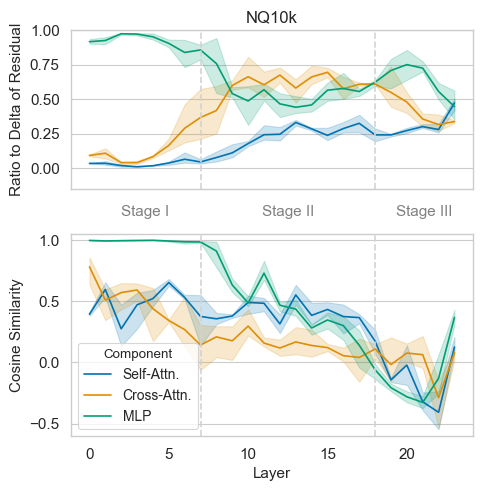

In [19]:
plt.rcParams.update({
    'axes.titlesize': 12,      # Column titles
    'axes.labelsize': 11,      # Axis labels
    'xtick.labelsize': 11,     # X-axis tick labels
    'ytick.labelsize': 11,     # Y-axis tick labels
    'legend.fontsize': 10      # Legend text
})

row_order = ["Ratio to Delta of Residual", "Cosine Similarity"]
line_positions = [7, 18]  # For Stage II start at 3, Stage III start at 6
labels = ['Stage I', 'Stage II', 'Stage III']



fig, axes = plt.subplots(2, 1, figsize=(5,5), gridspec_kw={'height_ratios': [11, 14]}) # 4 * 3
fig.subplots_adjust(hspace=0, wspace=0)

for col, model in enumerate(df_both['Model'].unique()):
    print(col, model)
    axes[col].set_title(model)


legend_added = False
for row in range(2):
    for col in range(1):
        # Select data for this specific subplot
        subset = df_both[(df_both['func'] == row_order[row]) & 
                         (df_both['Model'] == df_both['Model'].unique()[col])]
        
        

                # Plot with legend only in first subplot
        if not legend_added and row == 1 and col == 0:
            sb.lineplot(data=subset, x='Layer', y='value', 
                        hue='Component', ax=axes[row])
            legend_added = True
        else:
            sb.lineplot(data=subset, x='Layer', y='value', 
                        hue='Component', ax=axes[row], 
                        legend=False)


        axes[row].grid(axis='x', visible=False)
        # Set specific y-limits
        if row == 0:
            axes[row].set_ylim(-0.15, 1)
        else:
            axes[row].set_ylim(-0.6, 1.05)
            ax = axes[row]
            ax.text((0 + line_positions[0]) / 2, ax.get_ylim()[0] * -2.14, labels[0], ha='center', va='top', fontsize=11, color='grey')
            ax.text((line_positions[0] + line_positions[1]) / 2, ax.get_ylim()[0] * -2.14, labels[1], ha='center', va='top', fontsize=11, color='grey')
            ax.text((line_positions[1] + ax.get_xlim()[1]) / 2, ax.get_ylim()[0] * -2.14, labels[2], ha='center', va='top', fontsize=11, color='grey')
    
        if row == 0:
            axes[row].set_xlabel('')
            axes[row].set_xticklabels([])

                
        
        
        # Add vertical lines
        axes[row].axvline(x=line_positions[0], color='lightgrey', linestyle='--')
        axes[row].axvline(x=line_positions[1], color='lightgrey', linestyle='--')

# Y-axis labels for rows
axes[1].set_ylabel('Cosine Similarity')
axes[0].set_ylabel('Ratio to Delta of Residual')

plt.tight_layout()
plt.savefig("ratio_cosine_sample.pdf") 

## Rank Plots
### Data Loading

In [22]:
def get_ranks_df(checkpoint):
    data_path = f"{checkpoint}/all_ranks_correct_doc.csv"
    df =  pd.read_csv(data_path)

    def convert(x):
        try:
            return float(x)
        except:
            return float(x.replace('tensor(', '')[:-1])
    df['Rank'] = df['value'].map(convert)
    df = df.rename(columns={'layer': 'Layer', 'component': 'Component'})
    
    return df

def load_trivia_ranks(checkpoint, N=1500):
    data_path = f"{checkpoint}/all_ranks_correct_doc_{N}.json"
    data = json.load(open(data_path))
    df = pd.DataFrame(data)
    df = df.rename(columns={'layer': 'Layer', 'component': 'Component', 'value': 'Rank'})
    return df


In [23]:
example_data = "../../sample_output"
complete_ds_ranks = get_ranks_df(example_data)
complete_ds_ranks['Model'] = "NQ10k"

In [24]:
mask1 = ((complete_ds_ranks['Component'] == 'Mean Doc-IDs') |  (complete_ds_ranks['Component'] == 'Mean Non-Doc-IDs') | (complete_ds_ranks['Component'] == 'Residual After Layer'))
mask2 = (complete_ds_ranks['Component'] == 'Cross-Attn. Output') |  (complete_ds_ranks['Component'] == 'MLP Output')  | (complete_ds_ranks['Component'] == 'Residual After Layer') #| (complete_ds_ranks['Component'] == 'Residual After Cr.Attn'))


df_rank_all = complete_ds_ranks[mask1]
df_rank_all['func'] = "1"
df_ranks_comp = complete_ds_ranks[mask2]
df_ranks_comp['func'] = "2"


df_ranks = pd.concat([df_rank_all, df_ranks_comp])

/var/folders/_2/yzx8n5x97258ffcjrdm3k3xw0000gp/T/ipykernel_28009/3822925976.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rank_all['func'] = "1"
/var/folders/_2/yzx8n5x97258ffcjrdm3k3xw0000gp/T/ipykernel_28009/3822925976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ranks_comp['func'] = "2"


### Plot

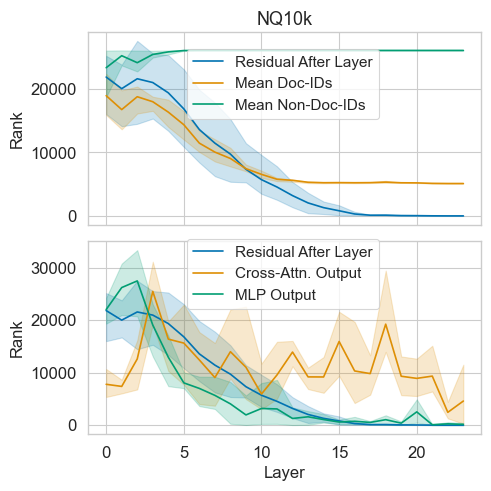

In [26]:
plt.rcParams.update({
    'axes.titlesize': 13,      # Column titles
    'axes.labelsize': 12,      # Axis labels
    'xtick.labelsize': 12,     # X-axis tick labels
    'ytick.labelsize': 12,     # Y-axis tick labels
    'legend.fontsize': 11      # Legend text
})

row_order = ["1", "2"]
common_component = 'Residual After Layer'
other_components = [comp for comp in df_ranks['Component'].unique() if comp != common_component]
line_positions = [7, 18]  # For Stage II start at 3, Stage III start at 6
labels = ['Stage I', 'Stage II', 'Stage III']


model_list = ['NQ10k']

fig, axes = plt.subplots(2, len(model_list), figsize=(5,5)) 
fig.subplots_adjust(hspace=0, wspace=0)



for col, model in enumerate(model_list):
    axes[col].set_title(model)


legend_added = False
for row in range(2):
    for col in range(len(model_list)):
        # Select data for this specific subplot
        subset = df_ranks[(df_ranks['func'] == row_order[row]) & 
                         (df_ranks['Model'] == model_list[col])]
        
        
        if row == 0:
            hue_order = ['Residual After Layer', 'Mean Doc-IDs', 'Mean Non-Doc-IDs']
        else:
            hue_order = ['Residual After Layer', 'Cross-Attn. Output', 'MLP Output']
        if col == 0:
            

            sb.lineplot(data=subset, x='Layer', y='Rank', hue='Component', ax=axes[row], hue_order=hue_order)
            legend_added = True

            if row==0 and col==0:
                axes[row].legend(loc=(0.25, 0.55))
            elif row==1 and col ==0:
                axes[row].legend(loc=(0.25, 0.65))

        else:
            sb.lineplot(data=subset, x='Layer', y='Rank', hue='Component', ax=axes[row,col], 
                        legend=False, hue_order=hue_order)


        if row == 0:
            axes[row].set_xlabel('')
            axes[row].set_xticklabels([])

            


plt.tight_layout()
plt.savefig("ranks_sample.pdf") 